___________________________________________________________________________________________________________
# Introduction to Pytorch - part2
### (based on the [60 min blitz Deep Learning with Pytorch] (https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) )

## 1. Tensors
## 2. A Gentle Introduction to ``torch.autograd``
## 3. Neural Networks
## 4. Train a Classifier

__________________________________________________________________________________________________________________________________________________________________________________________________________


# 2. A Gentle Introduction to ``torch.autograd``
---------------------------------

**``torch.autograd`` is PyTorch’s automatic differentiation engine that powers
neural network training. In this section, you will get a conceptual
understanding of how autograd helps a neural network train.**

**When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.**


To compute those gradients, PyTorch has a built-in differentiation engine calle``d torch.autogr``a
. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the follo manner:ner:


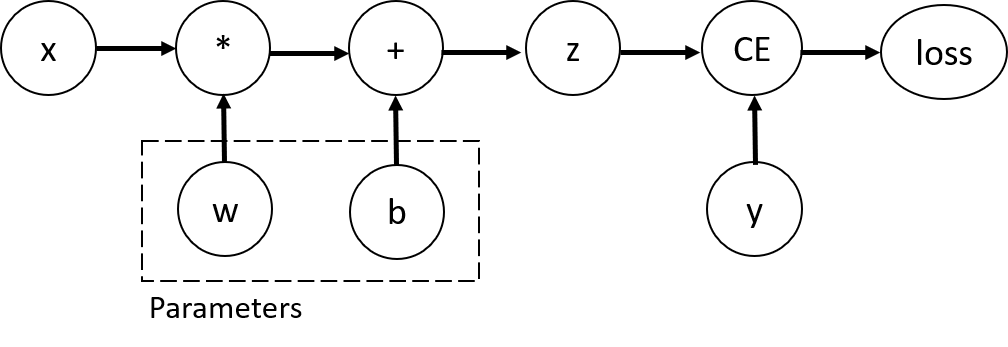

In this network, w and b are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the ``requires_grad`` property of those tensors.

**NOTE:** You can set the value of requires_grad when creating a tensor, or later by using ``x.requires_grad_(True)`` method.

In [4]:
import torch
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

print(x)
print(w)
print(b)
print(z)

print(y)
print(loss)

tensor([1., 1., 1., 1., 1.])
tensor([[-0.1067, -0.2149, -1.2540],
        [ 1.1494, -0.1962, -1.1731],
        [ 0.3784, -0.4695, -1.9333],
        [-1.0746,  0.4463,  0.3427],
        [ 1.3316,  0.3336, -1.0046]], requires_grad=True)
tensor([ 1.3599,  0.3068, -1.6394], requires_grad=True)
tensor([ 3.0381,  0.2060, -6.6617], grad_fn=<AddBackward0>)
tensor([0., 0., 0.])
tensor(1.2959, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


A function that we apply to tensors to construct computational graph is in fact an object of class ``Function``. 

This object knows how to compute the function in the forward direction, and also how to compute its derivative during the backward propagation step. A reference to the backward propagation function is stored in grad_fn property of a tensor. 

In [5]:
print(f"Gradient function for x = {x.grad_fn}")
print(f"Gradient function for y = {y.grad_fn}")
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for x = None
Gradient function for y = None
Gradient function for z = <AddBackward0 object at 0x000001E96C9FE260>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x000001E96CBB8430>


## Computing Gradients
To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need $$\frac{dloss}{dw}$$ and $$\frac{dloss}{db}$$ under some fixed values of ``x`` and ``y``

To compute those derivatives, we call ``loss.backward()``,and then retrieve the values from ``w.grad`` and ``b.grad``:

In [6]:
loss.backward()
print("w.grad:")
print(w.grad)
print("b.grad:")
print(b.grad)

w.grad:
tensor([[0.3181, 0.1838, 0.0004],
        [0.3181, 0.1838, 0.0004],
        [0.3181, 0.1838, 0.0004],
        [0.3181, 0.1838, 0.0004],
        [0.3181, 0.1838, 0.0004]])
b.grad:
tensor([0.3181, 0.1838, 0.0004])


C:\Python311\Lib\site-packages\torch\autograd\__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


**NOTE**

We can only obtain the grad properties for the leaf nodes of the computational graph, which have ``requires_grad`` property set to ``True``. 

For all other nodes in our graph, gradients will not be available.

We can only perform gradient calculations using ``backward`` once on a given graph, for performance reasons.

If we need to do several backward calls on the same graph, we need to pass ``retain_graph=True`` to the ``backward`` call.

## Disabling Gradient Tracking
By default, all tensors with ``requires_grad=True`` are tracking their computational history and support gradient computation.

However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. 

We can stop tracking computations by surrounding our computation code with ``torch.no_grad()`` block:

In [11]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True


'\nwith torch.no_grad():\n    z = torch.matmul(x, w)+b\nprint(z.requires_grad)\n'


## NN Background

**Neural networks (NNs) are a collection of nested functions that are
executed on some input data. These functions are defined by *parameters*
(consisting of weights and biases), which in PyTorch are stored in
tensors.**

**Training a NN happens in two steps:**

**Forward Propagation**: In forward prop, the NN makes its best guess
about the correct output. It runs the input data through each of its
functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters
proportionate to the error in its guess. It does this by traversing
backwards from the output, collecting the derivatives of the error with
respect to the parameters of the functions (*gradients*), and optimizing
the parameters using gradient descent. For a more detailed walkthrough
of backprop, check out this [video from
3Blue1Brown] (https://www.youtube.com/watch?v=tIeHLnjs5U8).

### Example in PyTorch

Let's take a look at a single training step.
For this example, we load a pretrained resnet18 model from ``torchvision``.
We create a random data tensor to represent a single image with 3 channels, and height & width of 64,
and its corresponding ``label`` initialized to some random values.



In [15]:
import torch, torchvision
from torch import nn

**download the model and save the model into path to be used later without downloading**

In [12]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
print(model)

PATH = r'D:\AI\Lab\resnetModel\resnet18.pth'
#save model parameters in dictionary
torch.save(model.state_dict(), PATH) #state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**load the model from path**

In [13]:
#from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=None)

PATH = r'D:\AI\Lab\resnetModel\resnet18.pth'
#LOAD model parameters in dictionary
model.load_state_dict(torch.load(PATH))

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**change number of features if needed**

In [16]:
n_features = 5
model.fc = nn.Linear(model.fc.in_features, n_features)
print(model.fc )

Linear(in_features=512, out_features=5, bias=True)


**create input data**

In [39]:
data = torch.rand(1, 3, 64, 64)
print(data.size())
#x= torch.count_nonzero(data, dim=-2)
#print(x)
print(data)

torch.Size([1, 3, 64, 64])
tensor([[[[0.1033, 0.4358, 0.3529,  ..., 0.1865, 0.7903, 0.3186],
          [0.6606, 0.5478, 0.2796,  ..., 0.5896, 0.4598, 0.4833],
          [0.1972, 0.9118, 0.3527,  ..., 0.3543, 0.0954, 0.3533],
          ...,
          [0.9667, 0.5492, 0.4358,  ..., 0.3313, 0.1753, 0.1909],
          [0.4517, 0.2467, 0.0828,  ..., 0.8535, 0.5876, 0.0445],
          [0.9913, 0.5371, 0.6573,  ..., 0.9180, 0.3586, 0.4642]],

         [[0.1290, 0.1113, 0.2680,  ..., 0.8254, 0.3608, 0.7715],
          [0.2252, 0.4883, 0.3717,  ..., 0.1680, 0.1650, 0.2221],
          [0.0621, 0.9562, 0.0274,  ..., 0.1112, 0.5241, 0.8643],
          ...,
          [0.3892, 0.2721, 0.4071,  ..., 0.0379, 0.2711, 0.2863],
          [0.9161, 0.4244, 0.7536,  ..., 0.6805, 0.3556, 0.8560],
          [0.8922, 0.1264, 0.0643,  ..., 0.0283, 0.3656, 0.3289]],

         [[0.0033, 0.4019, 0.2627,  ..., 0.8854, 0.4746, 0.5957],
          [0.8635, 0.3647, 0.1779,  ..., 0.3657, 0.6348, 0.2939],
          [0.01

**create labels (random in this training); the size of the labels should be compatible with features (and therefore with predictions)**

In [21]:
labels = torch.rand(1, 5)
print(labels)
print(labels.size())
x= torch.count_nonzero(labels, dim=+1)
#print(labels)
print(x)

tensor([[0.2630, 0.8629, 0.9487, 0.0269, 0.6449]])
torch.Size([1, 5])
tensor([5])


**Next, we run the input data through the model through each of its layers to make a prediction.
This is the *forward pass*.**


In [46]:
prediction = model(data) # forward pass
print(prediction)
#x= torch.count_nonzero(prediction, dim=+1)
print(prediction.size())

tensor([[-5.1747, -5.8342, -5.2481, -4.0533, -3.9232]],
       grad_fn=<AddmmBackward0>)
torch.Size([1, 5])


**We use the model's prediction and the corresponding label to calculate the error (*loss*).**

In [47]:
loss = (prediction - labels).sum()
print(loss)

tensor(-26.9800, grad_fn=<SumBackward0>)


**The next step is to backpropagate this error through the network.
Backward propagation is kicked off when we call ``.backward()`` on the error tensor.
Autograd then calculates and stores the gradients for each model parameter in the parameter's ``.grad`` attribute.**


In [48]:
loss.backward() # backward pass

**Next, we load an optimizer, in this case stochastic gradient descent **SGD** with a learning rate of 0.01 and momentum of 0.9.
We register all the parameters of the model in the optimizer.**

In [49]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Finally, we call ``.step()`` to initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in ``.grad``.

In [50]:
optim.step() #gradient descent

## Differentiation in Autograd

**Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be tracked.**




In [27]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)
print(a)
print(b)

tensor([2., 3.], requires_grad=True)
tensor([6., 4.], requires_grad=True)


**We create another tensor ``Q`` from ``a`` and ``b``.**

\begin{align}Q = 3a^3 - b^2\end{align}


In [29]:
Q = 3*a**3 - b**2

**Let's assume ``a`` and ``b`` to be parameters of an NN, and ``Q``
to be the error. In NN training, we want gradients of the error
w.r.t. parameters, i.e.**

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


**When we call ``.backward()`` on ``Q``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.**

**We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself, i.e.**

\begin{align}\frac{dQ}{dQ} = 1\end{align}



In [30]:
external_grad = torch.tensor([1., 1.])

Q.backward(gradient=external_grad)

**Gradients are now deposited in ``a.grad`` and ``b.grad``**

**check if collected gradients are correct**

In [31]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


## Computational Graph


Conceptually, autograd keeps a record of data (tensors) & all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of [Function] (https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor, and
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:

- computes the gradients from each ``.grad_fn``,
- accumulates them in the respective tensor’s ``.grad`` attribute, and
- using the chain rule, propagates all the way to the leaf tensors.**


** NOTE: DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>


### Exclusion from the DAG


**``torch.autograd`` tracks operations on all tensors which have their
``requires_grad`` flag set to ``True``. For tensors that don’t require
gradients, setting this attribute to ``False`` excludes it from the
gradient computation DAG.**

**The output tensor of an operation will require gradients even if only a
single input tensor has ``requires_grad=True``.**

In [3]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


**In a NN, parameters that don't compute gradients are usually called **frozen parameters**.
It is useful to "freeze" part of your model if you know in advance that you won't need the gradients of those parameters
(this offers some performance benefits by reducing autograd computations).**

**Another common usecase where exclusion from the DAG is important is for transfer learning** (see
[finetuning a pretrained network](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html))

**In transfer learning, we freeze most of the model and typically only modify the classifier layers (last fully connected layers) to make predictions on new labels.
Let's walk through a small example to demonstrate this. As before, we load a pretrained resnet18 model, and freeze all the parameters.**

In [32]:
from torch import nn, optim

#model = torchvision.models.resnet18(pretrained=True)
model = resnet18(weights=None)

PATH = r'D:\AI\Lab\resnetModel\resnet18.pth'
#LOAD model parameters in dictionary
model.load_state_dict(torch.load(PATH))

#print(model)



print(model.conv1 )
print(model.conv1.weight.detach().numpy() )
print("+++++++++++++++++++++++++++++++++++++")
print(model.fc )
print(model.fc.weight.detach().numpy() )

# Freeze all the parameters in the network
for param in model.parameters():
    param.requires_grad = False

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
[[[[-1.04193492e-02 -6.13560760e-03 -1.80977571e-03 ...  5.66148497e-02
     1.70833264e-02 -1.26938839e-02]
   [ 1.10827060e-02  9.52757336e-03 -1.09926917e-01 ... -2.71237552e-01
    -1.29074901e-01  3.74236982e-03]
   [-6.94335019e-03  5.90889715e-02  2.95482218e-01 ...  5.19718885e-01
     2.56324232e-01  6.35725409e-02]
   ...
   [-2.75347717e-02  1.60450842e-02  7.25949779e-02 ... -3.32849443e-01
    -4.20575589e-01 -2.57814825e-01]
   [ 3.06125693e-02  4.09597456e-02  6.28496706e-02 ...  4.13839936e-01
     3.93589228e-01  1.66058436e-01]
   [-1.37361288e-02 -3.67455627e-03 -2.40843575e-02 ... -1.50699466e-01
    -8.22297409e-02 -5.78277605e-03]]

  [[-1.13972435e-02 -2.66190711e-02 -3.46408449e-02 ...  3.25206555e-02
     6.62208884e-04 -2.57434826e-02]
   [ 4.56866063e-02  3.36034410e-02 -1.04527377e-01 ... -3.12528163e-01
    -1.60506710e-01 -1.28256797e-03]
   [-8.37297121e-04  9.84199569e-02  4.021

**Let's say we want to finetune the model on a new dataset with 10 labels.
In resnet, the classifier is the last linear layer ``model.fc``.
We can simply replace it with a new linear layer (unfrozen by default)
that acts as our classifier.**



In [37]:
model.fc = nn.Linear(512, 5)

**Now all parameters in the model, except the parameters of ``model.fc``, are frozen.
The only parameters that compute gradients are the weights and bias of ``model.fc``.
This means also that during traininig, the only parameters that are computing gradients (and hence updated in gradient descent)
are the weights and bias of the classifier (`model.fc`).**

### NOTE:
 The same exclusionary functionality is available as a context manager in
[`torch.no_grad()`] (https://pytorch.org/docs/stable/generated/torch.no_grad.html), that we will be using for *Transfer Learning*



In [51]:
print(model.conv1 )
print(model.conv1.weight.detach().numpy() )
print("+++++++++++++++++++++++++++++++++++++")
print(model.fc )
print(model.fc.weight.detach().numpy() )

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
[[[[-1.04193492e-02 -6.13560760e-03 -1.80977571e-03 ...  5.66148497e-02
     1.70833264e-02 -1.26938839e-02]
   [ 1.10827060e-02  9.52757336e-03 -1.09926917e-01 ... -2.71237552e-01
    -1.29074901e-01  3.74236982e-03]
   [-6.94335019e-03  5.90889715e-02  2.95482218e-01 ...  5.19718885e-01
     2.56324232e-01  6.35725409e-02]
   ...
   [-2.75347717e-02  1.60450842e-02  7.25949779e-02 ... -3.32849443e-01
    -4.20575589e-01 -2.57814825e-01]
   [ 3.06125693e-02  4.09597456e-02  6.28496706e-02 ...  4.13839936e-01
     3.93589228e-01  1.66058436e-01]
   [-1.37361288e-02 -3.67455627e-03 -2.40843575e-02 ... -1.50699466e-01
    -8.22297409e-02 -5.78277605e-03]]

  [[-1.13972435e-02 -2.66190711e-02 -3.46408449e-02 ...  3.25206555e-02
     6.62208884e-04 -2.57434826e-02]
   [ 4.56866063e-02  3.36034410e-02 -1.04527377e-01 ... -3.12528163e-01
    -1.60506710e-01 -1.28256797e-03]
   [-8.37297121e-04  9.84199569e-02  4.021